# Functions defining

In [35]:
##Functions
from Bio import SeqIO
import json
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


def getProteinArray(uniprot_file):   
        parkinson_sequences = SeqIO.parse(open(uniprot_file),'fasta')
        #retrieving protein names and IDs
        
        
        protein_info = []
        for fasta in parkinson_sequences:
                name, sequence, description= fasta.id, str(fasta.seq), str(fasta.description)
                id = name.split("|")
                entry =  [id[1], id[2], description, sequence]
                protein_info.append(entry)
        return protein_info

def get_Full_Description(uniprot_id):

    #Get the Uniprot data
    response = requests.get('http://www.uniprot.org/uniprot/' + uniprot_id + '.txt')
    data = response.text
    
    return data

def xml_get_NucleotideVar(uniprot_id):
    
    #Get the Uniprot data in xml
    response = requests.get('http://www.uniprot.org/uniprot/' + uniprot_id + '.xml')
    data = response.text
    
def get_NucleotideVar(uniprot_id):

    #Get the Uniprot data
    response = requests.get('http://www.uniprot.org/uniprot/' + uniprot_id + '.txt')
    data = response.text
    data_lines = data.splitlines()
    
    # Look for the RP identifiers followed by NUCLEOTIDE SEQUENCE
    rp_ids = set()
    for line in data_lines:
        if line.startswith('RP') and "VARIANT" in line:
            rp_ids.add(line)
    
    return "\n".join(rp_ids)

def get_full_annotation(uniprot_id):
    distinct_terms = set()
    
    # First get the Uniprot data
    response = requests.get('http://www.uniprot.org/uniprot/' + uniprot_id + '.txt')
    data = response.text
    data_lines = data.splitlines()
    
    # Look for the GO identifiers in the response and save them in a set
    go_ids = set()
    for line in data_lines:
        if line.startswith('DR   GO'):
            line_prefix, go_id, go_term_full, evidence_code = line.split(';')
            go_id = go_id.strip()
            go_ids.add(go_id)
    
    # Construct the URL for the QuickGO Request with all those GO identifiers
    the_url = 'https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/'
    the_url += ','.join(go_ids)
    the_url += '/ancestors?relations=is_a'
    
    # Make the request and parse the results
    response = requests.get(the_url)
    anc_data = json.loads(response.text)
    results = anc_data['results']
    for record in results:
        distinct_terms.update(record['ancestors'])
                                        
    return distinct_terms

def get_term_info(go_id):
    the_url = 'https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/' + go_id
    response = requests.get(the_url)
    data = json.loads(response.text)
    
    record = data['results'][0] # Get the first result, because we are only requesting one!
    
    # Return a dictionary that contains the information of this GO term
    go_info = {
        'go_id': record['id'],
        'aspect': record['aspect'],
        'name': record['name'],
        'definition': record['definition']['text'],
        'obsolete': record['isObsolete'],
    }
    
    return go_info

def heat_plot_analysis(protein_label, protein_terms, show_graph):
    protein_annotation_count = []
    for protein1 in protein_terms.values():
            pac_line = []
            for protein2 in protein_terms.values():
                    l1 = len(protein1)
                    l2 = len(protein2)
                    
                    if(l1 > l2):
                            count_ref = l1
                    else:
                            count_ref = l2
                    p = set(protein1).intersection(protein2)
                    pac_line.append(round((len(p)*1.0/count_ref)*100))
            
            protein_annotation_count.append(pac_line)

    fig, ax = plt.subplots()
    im = ax.imshow(protein_annotation_count)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(protein_label)))
    ax.set_yticks(np.arange(len(protein_label)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(protein_label)
    ax.set_yticklabels(protein_label)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.

    ax.set_title("Relative number of common annotations:")
    fig.tight_layout()
    
    if(show_graph == True):
        plt.show()
    else:
        output = []
        header = "\t\t"+"\t\t".join(protein_label)
        output.append(header)
        for index, protein in enumerate(protein_annotation_count):
            output.append(protein_label[index] + "\t" + "\t\t".join(str(e) for e in protein))

    
    return output
            
            

# Retrieving the protein, gene sets retrieved from uniprot
The entries on the uniprot database downloaded manually therefore the first step is open the .fasta file.
The file is going to be opened with SeqIO function parse that is going to format the output accordingly.

A quick rundown on the variables:
    protein_terms -> Dictionary with key "protein_id". Stores protein ontological terms associated with each found protein.
    protein_label -> Stores the labels for each protein
    all_terms -> As implied by the name stores every found ontological term. Will be used in the term count variable further on.

In [36]:
from Bio import SeqIO
import requests

OMIM="uniprot-database_(type_mim+168600).fasta"


protein_info = getProteinArray(OMIM)


#writting focus proteins to file
print("Retrieving protein names and IDs from "+ OMIM + "\n")
print("ProteinName\tProteinID\n")
for protein in protein_info:
        print(protein[1] + "\t" + protein[0] + "\n")


Retrieving protein names and IDs from uniprot-database_(type_mim+168600).fasta

ProteinName	ProteinID

PARK7_HUMAN	Q99497

PINK1_HUMAN	Q9BXM7

HTRA2_HUMAN	O43464

SYUA_HUMAN	P37840

GLCM_HUMAN	P04062

LRRK2_HUMAN	Q5S007

PRKN_HUMAN	O60260

SNCAP_HUMAN	Q9Y6H5

TM175_HUMAN	Q9BSA9

DJC13_HUMAN	O75165

TM230_HUMAN	Q96A57



# Correlation analysis

By looking at the correlation plot, there is a clear divide between 2 groups of proteins



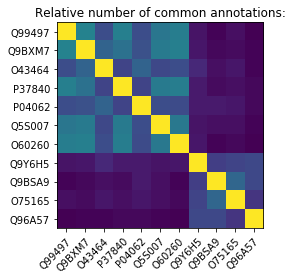

In [37]:
#Heatmap
print("By looking at the correlation plot, there is a clear divide between 2 groups of proteins\n")
corr_plot = heat_plot_analysis(protein_label, protein_terms, False)


GO ID analysis

In [38]:
import uniRetrieval
#GO term counting 
all_terms = []
for protein_id in protein_info:
    all_terms.extend(uniRetrieval.get_full_annotation(protein_id[1]))

term_counts = {term: all_terms.count(term) for term in all_terms}
distinct_terms = list(term_counts)

# showing distinct terms
print(distinct_terms)

KeyboardInterrupt: 

# Searching DrugBank for candidate drugs with target protein sequences in blast format

Although DrugBank has an api for programmatical access, there is no way to retrieve drugs for a given target sequence / id / protein name. Therefore we are going to print the fasta sequences stored earlier before and will use the tool available in https://www.drugbank.ca/structures/search/bonds/sequence manually.

# Results for this stage

The DrugBank Blast search was quite tame for some target proteins like PARK7_HUMAN, showing that the only "known"(present in the database) drug with relationship with this protein is actually copper! For others this was quite not the case with as far as 271 linked drugs to LRRK2_HUMAN, which are way too many to be studied one by one.

In [40]:
for protein in protein_info:
    print(">%s\n%s\n" % (protein[2], protein[3]))
    

>sp|Q99497|PARK7_HUMAN Protein/nucleic acid deglycase DJ-1 OS=Homo sapiens OX=9606 GN=PARK7 PE=1 SV=2
MASKRALVILAKGAEEMETVIPVDVMRRAGIKVTVAGLAGKDPVQCSRDVVICPDASLEDAKKEGPYDVVVLPGGNLGAQNLSESAAVKEILKEQENRKGLIAAICAGPTALLAHEIGFGSKVTTHPLAKDKMMNGGHYTYSENRVEKDGLILTSRGPGTSFEFALAIVEALNGKEVAAQVKAPLVLKD

>sp|Q9BXM7|PINK1_HUMAN Serine/threonine-protein kinase PINK1, mitochondrial OS=Homo sapiens OX=9606 GN=PINK1 PE=1 SV=1
MAVRQALGRGLQLGRALLLRFTGKPGRAYGLGRPGPAAGCVRGERPGWAAGPGAEPRRVGLGLPNRLRFFRQSVAGLAARLQRQFVVRAWGCAGPCGRAVFLAFGLGLGLIEEKQAESRRAVSACQEIQAIFTQKSKPGPDPLDTRRLQGFRLEEYLIGQSIGKGCSAAVYEATMPTLPQNLEVTKSTGLLPGRGPGTSAPGEGQERAPGAPAFPLAIKMMWNISAGSSSEAILNTMSQELVPASRVALAGEYGAVTYRKSKRGPKQLAPHPNIIRVLRAFTSSVPLLPGALVDYPDVLPSRLHPEGLGHGRTLFLVMKNYPCTLRQYLCVNTPSPRLAAMMLLQLLEGVDHLVQQGIAHRDLKSDNILVELDPDGCPWLVIADFGCCLADESIGLQLPFSSWYVDRGGNGCLMAPEVSTARPGPRAVIDYSKADAWAVGAIAYEIFGLVNPFYGQGKAHLESRSYQEAQLPALPESVPPDVRQLVRALLQREASKRPSARVAANVLHLSLWGEHILALKNLKLDKMVGWLLQQSAATLLANRLTEKCCVETKMKMLFLANLECETLCQAALLLCSWRAAL

>sp|O